In [1]:
# imports
import math
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

import unionfind_link as ufBase



In [2]:
# helper functions

def eucDistPoint(a,b):
    return math.sqrt(math.pow((a[0]-b[0]),2) + math.pow((a[1]-b[1]),2))

def eucDistNode(a,b):
    return math.sqrt(math.pow((a.x-b.x),2) + math.pow((a.y-b.y),2))



class Point:
    x = 0
    y = 0

    isUsed = False
    labelNum = 0

    def __init__(self, x,y):
        self.x = x
        self.y = y
        self.isUsed = False
        self.isDistAdded = False
        self.labelNum = 0

    def print(self):
        ret = str(self.x) + "x" + str(self.y) + " "
        return ret



def convert_to_nodes(points):
    nodes = []
    try:
        if (len(points) == 0): raise SystemError("need at least input with len > 0")
    
        if (not isinstance(points[0], list)):
            nodes = points
        else:
            if (len(points[0]) < 2): raise SystemError("need nodes, or at least list with list of [x,y]")
            labelNum = 0
            for p in points:
                node = Point(p[0],p[1])
                node.labelNum = labelNum
                labelNum += 1
                nodes.append(node)

        if not hasattr(nodes[0], 'x'): raise SystemError("need points in attribute x,y form or array of tuples!")

    except TypeError as e:
        print(e)
        raise SystemExit("ERROR: no container as input - ")
    
    return nodes






In [3]:
# MAIN

# version 2
#   without dendogram (Z), but with splitup decision


# = Clustering to closest+level+total
#=====================================

def linkage_closestPairs(nodes):

    clusts = ufBase.UnionFind()
    Z = []
    bestZ = []
    bestClus = None
    bestDist = 0

    # = preperation
    # - pair-dist
    pairDist_unsorted = []
    rest = nodes.copy()
    for p1 in nodes:
        rest.pop(0)
        for p2 in rest:
            d = eucDistNode(p1, p2)
            pairDist_unsorted.append((d, p1, p2))

    pairDist = sorted(pairDist_unsorted, key=lambda val: val[0])


    # - MAIN
    labelNewSetN = len(nodes)
    isChanged = True
    distDendo = 1
    dists = []
    while (isChanged):
        # run through levels
        isChanged = False

        # - determine all closest pairs for next level
        pairRest = pairDist.copy()
        pairRestInd = 0
        for pair in pairDist:
            pairRestInd += 1
            pA:Point = pair[1]
            pB:Point = pair[2]

            clusARoot:Point = clusts.findOrCreate(pA)
            clusBRoot:Point = clusts.findOrCreate(pB)

            if (clusARoot == clusBRoot):
                # already in same set
                pairRestInd -= 1
                del pairRest[pairRestInd]
                continue


            # HINT: early cancel condition, cause +global
            if (clusARoot.isUsed or clusBRoot.isUsed): 
                break


            # - inner MAIN
            clusRoot = clusts.union(pA, pB)
            isChanged = True
            pairRestInd -= 1
            del pairRest[pairRestInd]
            clusARoot.isUsed = True
            clusBRoot.isUsed = True
            clusRoot.isUsed = True


            # - dendogram
            Z.append([clusARoot.labelNum, clusBRoot.labelNum, 0, 0])

            clusRoot.labelNum = labelNewSetN
            labelNewSetN += 1


        if (not isChanged): break           # early break


        # - clear isUsed
        for p in nodes: p.isUsed = False


        # - apply dist
        #   HINT: apply before calc dist, cause then root not same like last entry
        for z in Z:
            if (z[2] == 0): z[2] = distDendo


        # - calc dist
        dist = 0
        distC = 0
        for pair in pairRest:
            pA:Point = pair[1]
            pB:Point = pair[2]

            clusARoot:Point = clusts.find(pA)
            clusBRoot:Point = clusts.find(pB)

            # HINT: still valid dist - if (clusARoot == None and clusBRoot == None)
            if (clusARoot != None and clusARoot == clusBRoot): continue     # same set, not counting

            if ((clusARoot != None and clusARoot.isUsed) 
                and (clusBRoot != None and clusBRoot.isUsed)): continue     # both sets used already
            
            if (pA.isUsed and pB.isUsed): continue                          # both single points used already -> skip
            if (clusBRoot != None and pA != clusBRoot and pA.isUsed and clusBRoot.isUsed): continue # both point and root differ and both used
            if (clusARoot != None and pB != clusARoot and pB.isUsed and clusARoot.isUsed): continue


            d = eucDistNode(pA, pB)
            dist += d
            distC += 1

            pA.isUsed = True
            pB.isUsed = True
            if (clusARoot != None): clusARoot.isUsed = True
            if (clusBRoot != None): clusBRoot.isUsed = True


        if (distC > 0):
            # HINT: best kernel-method, see AI: sum+squared+normalized
            dist = dist*dist/distC
            if (dist > bestDist):
                bestDist = dist
                bestClus = clusts.copy()
                bestZ = Z.copy()

        distDendo += dist


        # - clear isUsed
        for p in nodes: p.isUsed = False

        
        # - repeat loop
        pairDist = pairRest.copy()



    return (bestClus, Z)





In [4]:
# Run-Procedure

def run(X):
    # - container conversion if necessary
    nodes = convert_to_nodes(X)

    (clusts, Z) = linkage_closestPairs(nodes)
    # Z[-1][2] = Z[-1][2] /2          # beautify
    # Z[-1][2] = Z[-1][2] *3/4          # beautify

    printedRoots = []
    for p in nodes:
        root = clusts.find(p)
        if (root == None):
            print("[ " + p.print() + "]")
            continue
        try:
            printedRoots.index(root)
        except:
            print("[ " + clusts.print(root) + "]")
            printedRoots.append(root)


    # - plotting
    fig, axes = plt.subplots(1,2)
    fig.set_size_inches(24, 12)

    labels = []
    for i in range(0, len(X)):
        label = str(chr(65+i))
        labels.append(label)
        p = X[i]
        axes[0].scatter(p[0], p[1], marker='o', c='red')
        axes[0].annotate(label, (p[0], p[1]), size=24)


    dendrogram(Z,labels=labels) #plotting the dendogram

    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Data point')
    plt.ylabel('Distance')
    plt.show()




[ 1x3 ; 2.3x2.5 ; 2x3 ; 2x4 ; 1.7x3.5 ]
[ 3x1 ; 4x2 ]


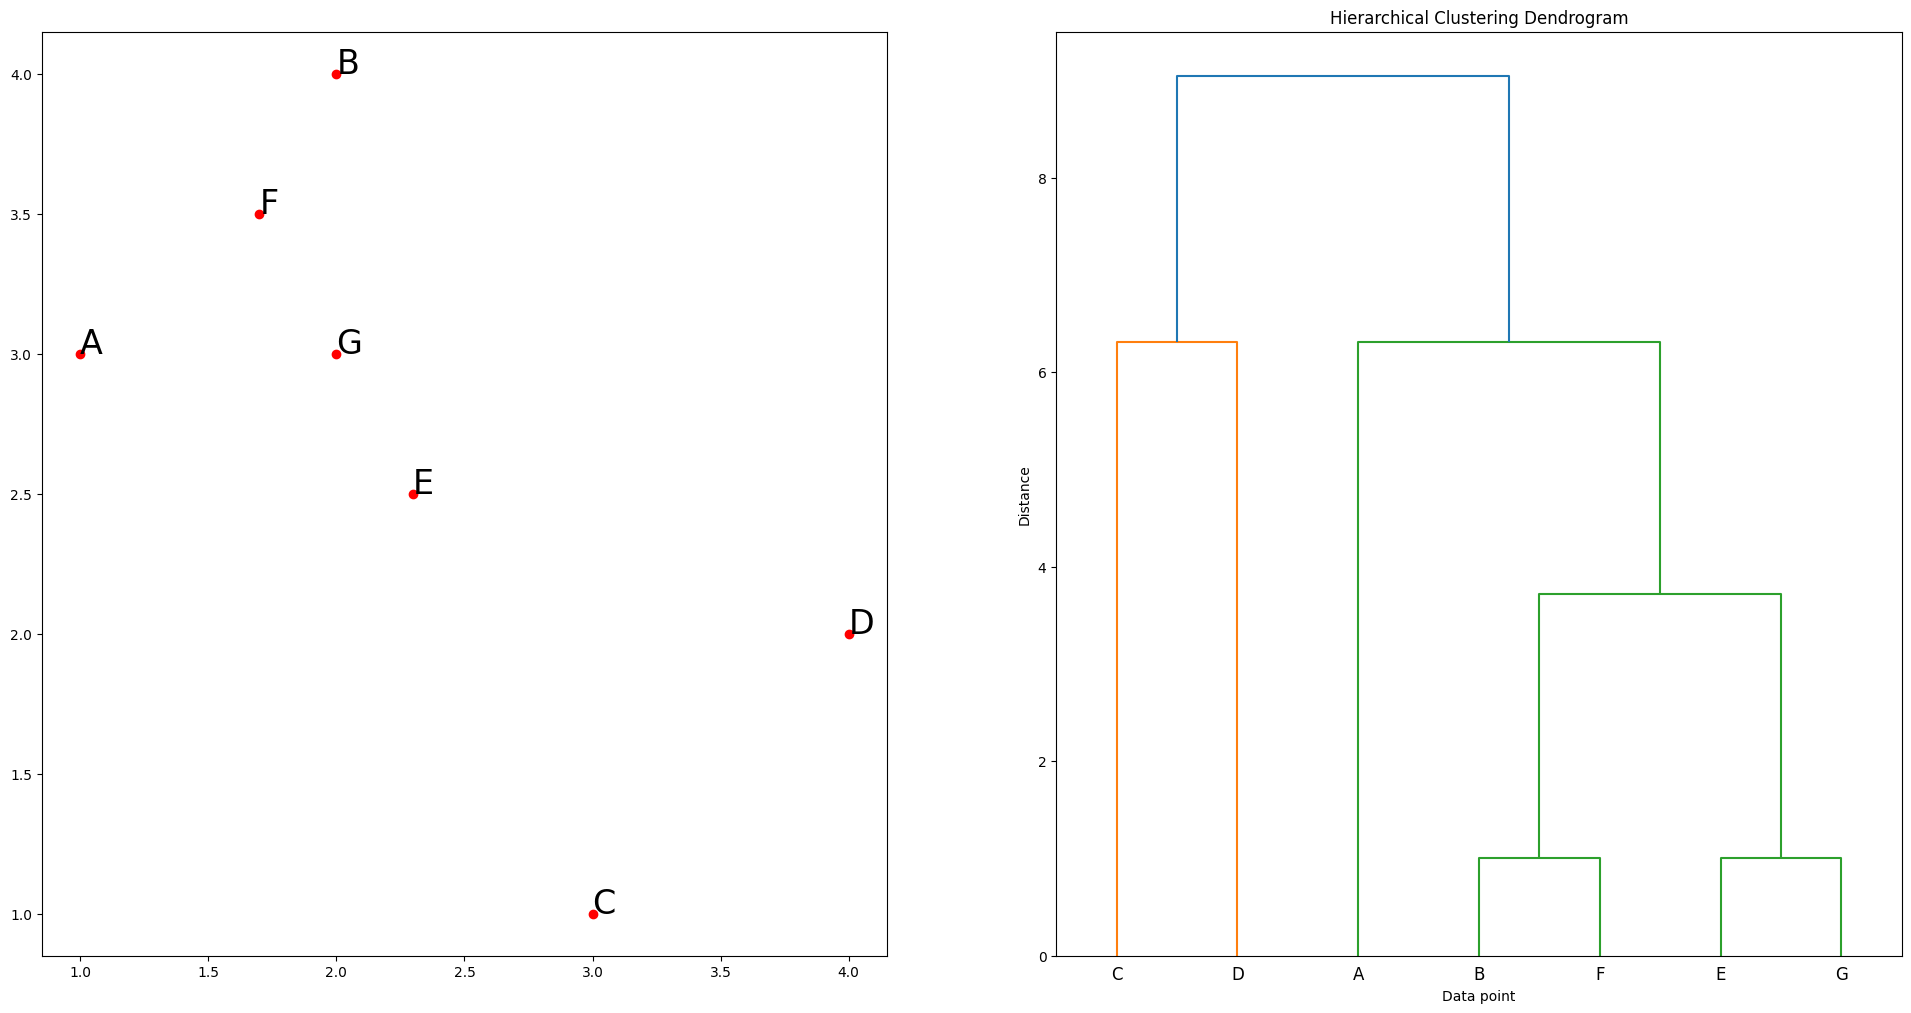

In [5]:
# TEST1

a = [1, 3]
b = [2, 4]
c = [3, 1]
d = [4, 2]
e = [2.3, 2.5]
f = [1.7, 3.5]
g = [2,3]


X = [a, b, c, d, e, f, g ] 

run(X)


[ 1x3 ; 2.3x2.6 ; 2x3 ; 2x4 ; 1.7x3.5 ]
[ 4x2 ; 3x1 ; 3.4x1.6 ]
[ 1.5x1 ; 1x1.5 ]


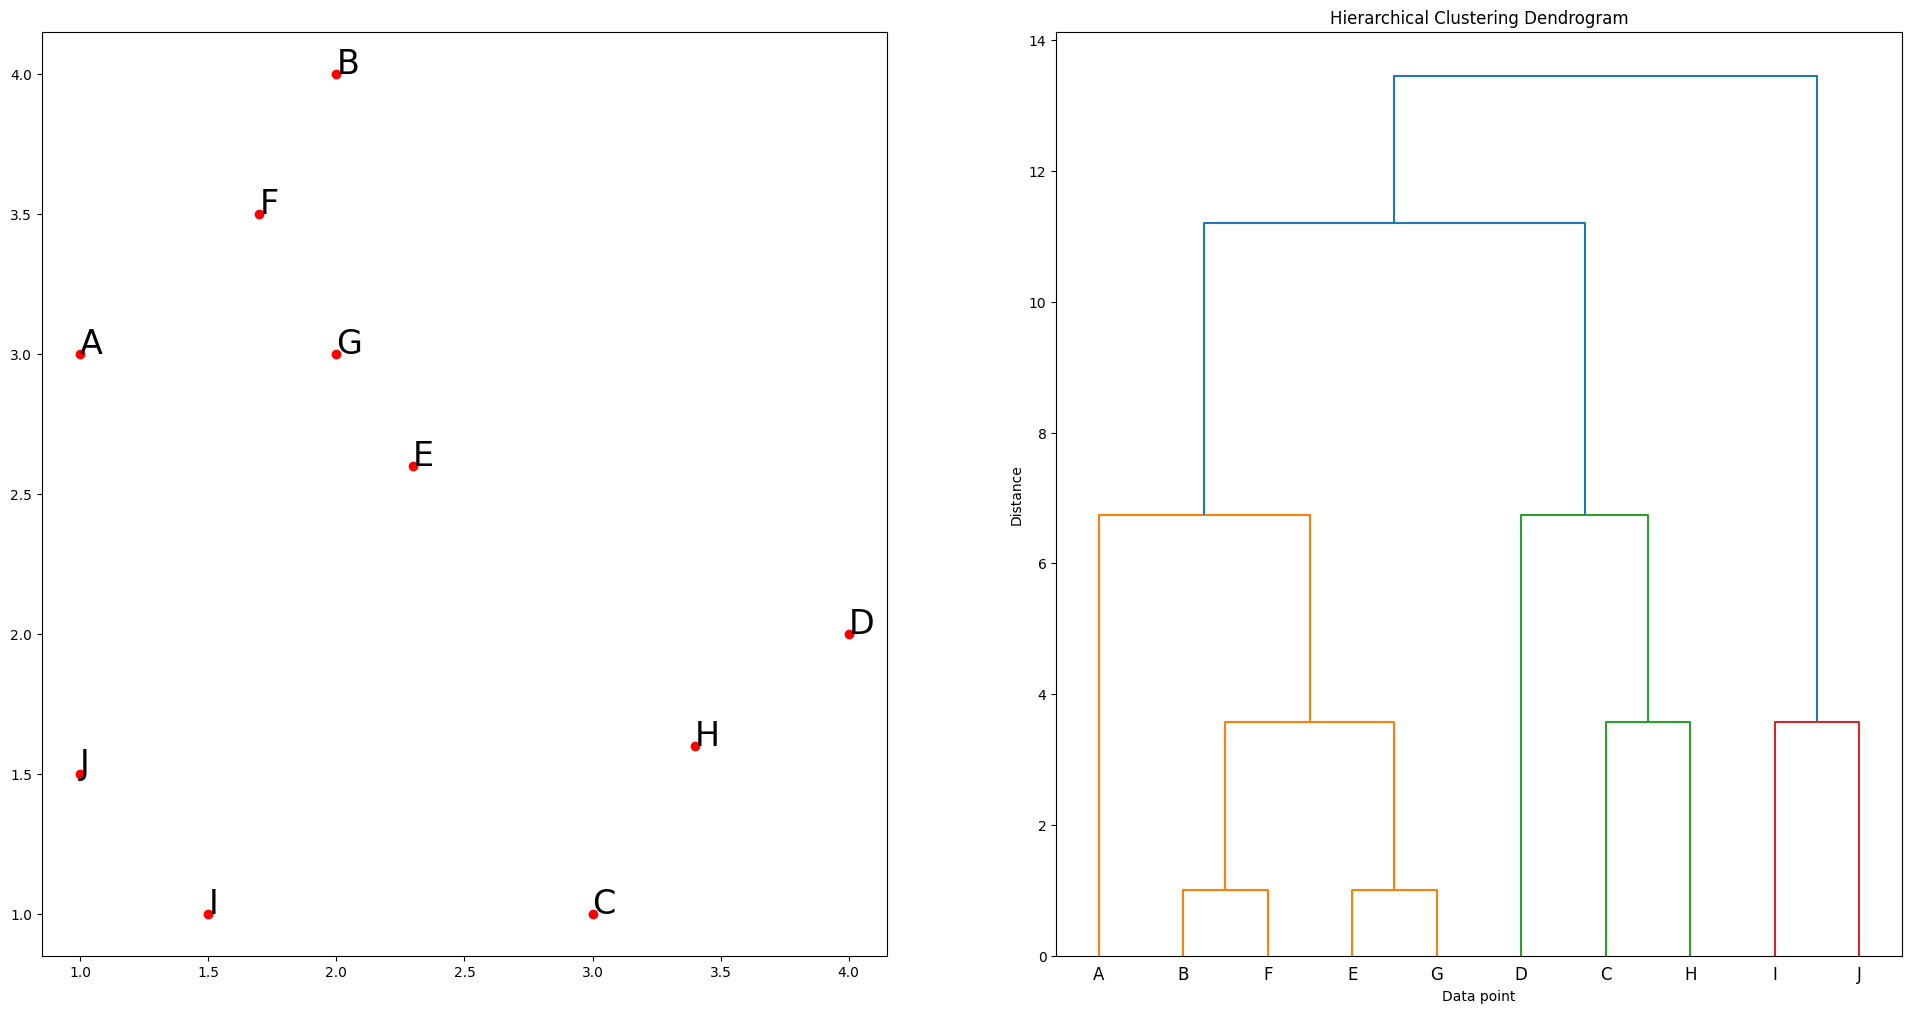

In [6]:
# TEST2

a = [1, 3]
b = [2, 4]
c = [3, 1]
d = [4, 2]
e = [2.3, 2.6]
f = [1.7, 3.5]
g = [2,3]
# h = [e[0]+1.6, e[0] ]
h = [3.4,1.6]

i = [1.5, 1]
j = [1, 1.5]

X = [a, b, c, d, e, f, g, h, i, j ] 

run(X)


[ 1x3 ; 2.3x2.6 ; 2x3 ; 2x4 ; 1.7x3.5 ]
[ 4x2 ; 3x1 ; 3.4x1.6 ]
[ 1.5x1 ; 1x1.5 ]
[ 3.8x3.8 ]


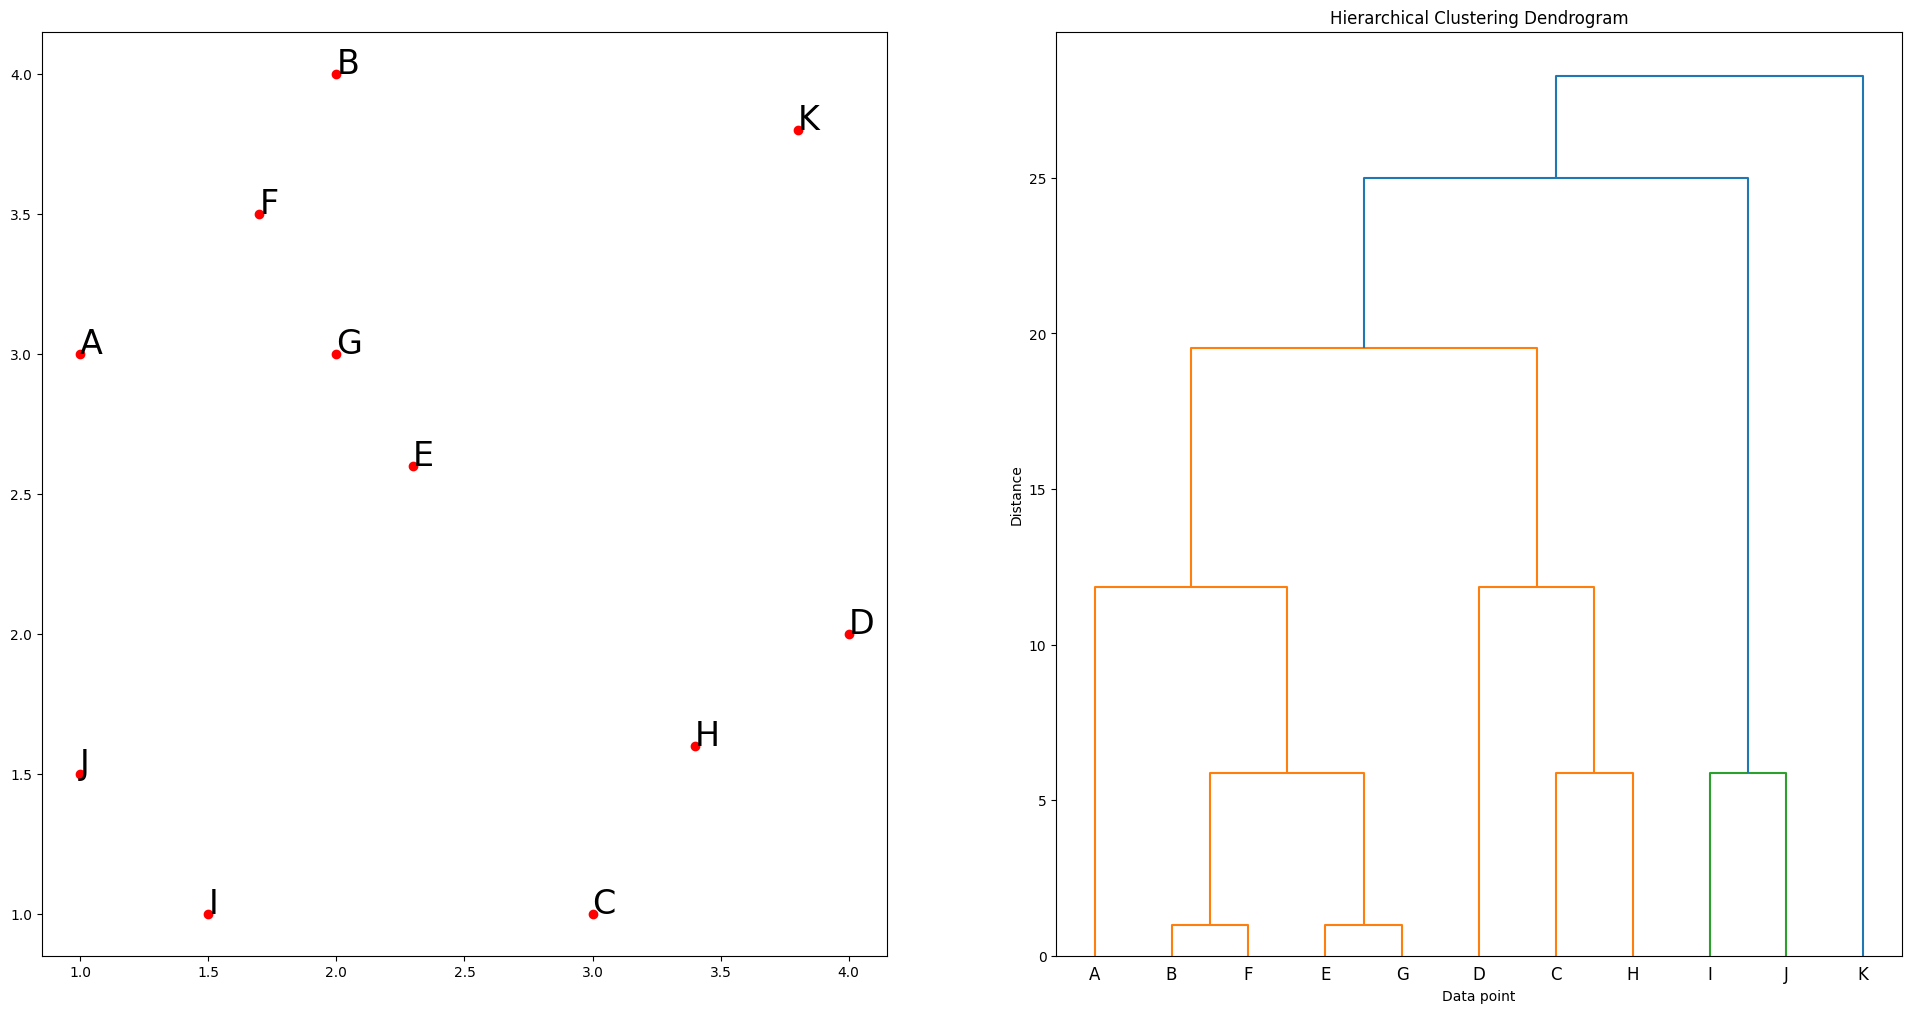

In [7]:
# TEST3

a = [1, 3]
b = [2, 4]
c = [3, 1]
d = [4, 2]
e = [2.3, 2.6]
f = [1.7, 3.5]
g = [2,3]
# h = [e[0]+1.6, e[0] ]
h = [3.4,1.6]

i = [1.5, 1]
j = [1, 1.5]

k = [3.8,3.8]

X = [a, b, c, d, e, f, g, h, i, j, k ] 

run(X)
